In [1]:
import os, matplotlib.pyplot as plt, numpy as np, pandas as pd, sys
import seaborn as sns#; sns.set()
from glob import glob
from datetime import datetime
from multiprocessing import Pool
from collections import Counter
from common_functions import load_data_reps, get_freq_clf, KMeans, plot_boxplot, plot_density, plot_figures

In [2]:
mt = "WT45C" #"Pus4KO30C" #"Pus1KO30C"
predictions = pd.read_csv("results/predictions_ncRNA_WT30C_%s.tsv.gz"%mt, sep="\t"); predictions.head()
predictions.columns, predictions["chr_pos.x"].head()

(Index(['X.Ref', 'pos', 'chr_pos.x', 'Heat', 'Reference', 'normal1_cov',
        'normal1_mis', 'normal1_c', 'heat1_cov', 'heat1_mis', 'heat1_c',
        'normal2_cov', 'normal2_mis', 'normal2_c', 'heat2_cov', 'heat2_mis',
        'heat2_c', 'diff_mis1', 'diff_mis2', 'New_Status', 'Prediction',
        'mis_normal_merged', 'mis_heat_merged'],
       dtype='object'), 0    snR86_snoRNA_396
 1    snR86_snoRNA_456
 2    snR86_snoRNA_457
 3    snR86_snoRNA_531
 4    snR86_snoRNA_537
 Name: chr_pos.x, dtype: object)

# ncRNA predictions

(51, 25) Index(['X.Ref', 'pos', 'chr_pos.x', 'Heat', 'Reference', 'normal1_cov',
       'normal1_mis', 'normal1_c', 'heat1_cov', 'heat1_mis', 'heat1_c',
       'normal2_cov', 'normal2_mis', 'normal2_c', 'heat2_cov', 'heat2_mis',
       'heat2_c', 'diff_mis1', 'diff_mis2', 'New_Status', 'Prediction',
       'mis_normal_merged', 'mis_heat_merged', 'chrom', 'chr_pos'],
      dtype='object')
[Counter({'No': 34, 'Yes': 11, 'Unm': 6}), Counter({'Known NonHeat-Sensitive': 34, 'Known Heat-Sensitive': 11, 'Novel': 6}), Counter({'Not Predicted': 35, 'Predicted': 16})]
['guppy3.0.3.hac/RNA235629_WT45C.bam', 'guppy3.0.3.hac/RNA574356_WT45C.bam', 'guppy3.0.3.hac/RNA574356_WT30C.bam', 'guppy3.0.3.hac/RNA235629_WT30C.bam'] ['RNA235629_WT45C', 'RNA574356_WT45C', 'RNA574356_WT30C', 'RNA235629_WT30C']


/home/lpryszcz/src/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


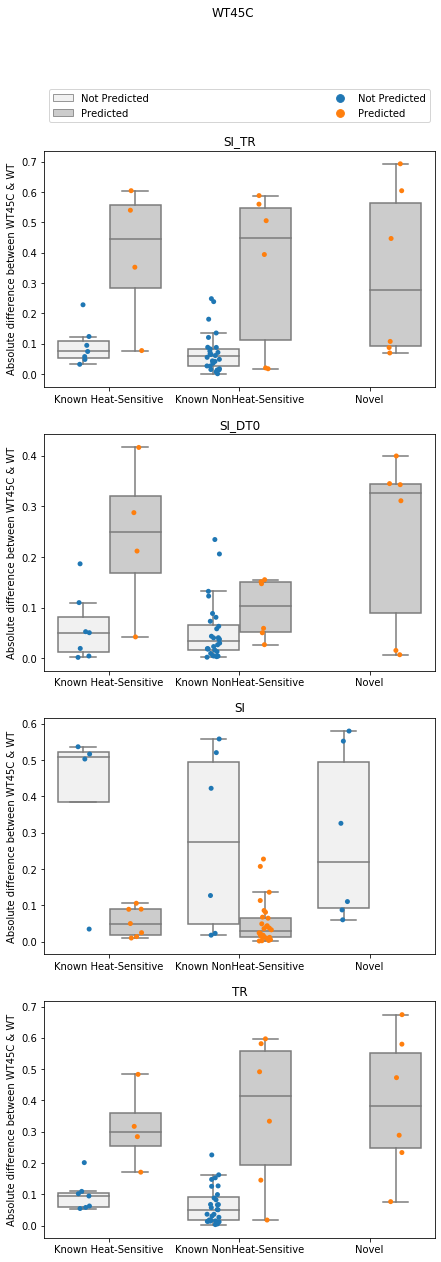

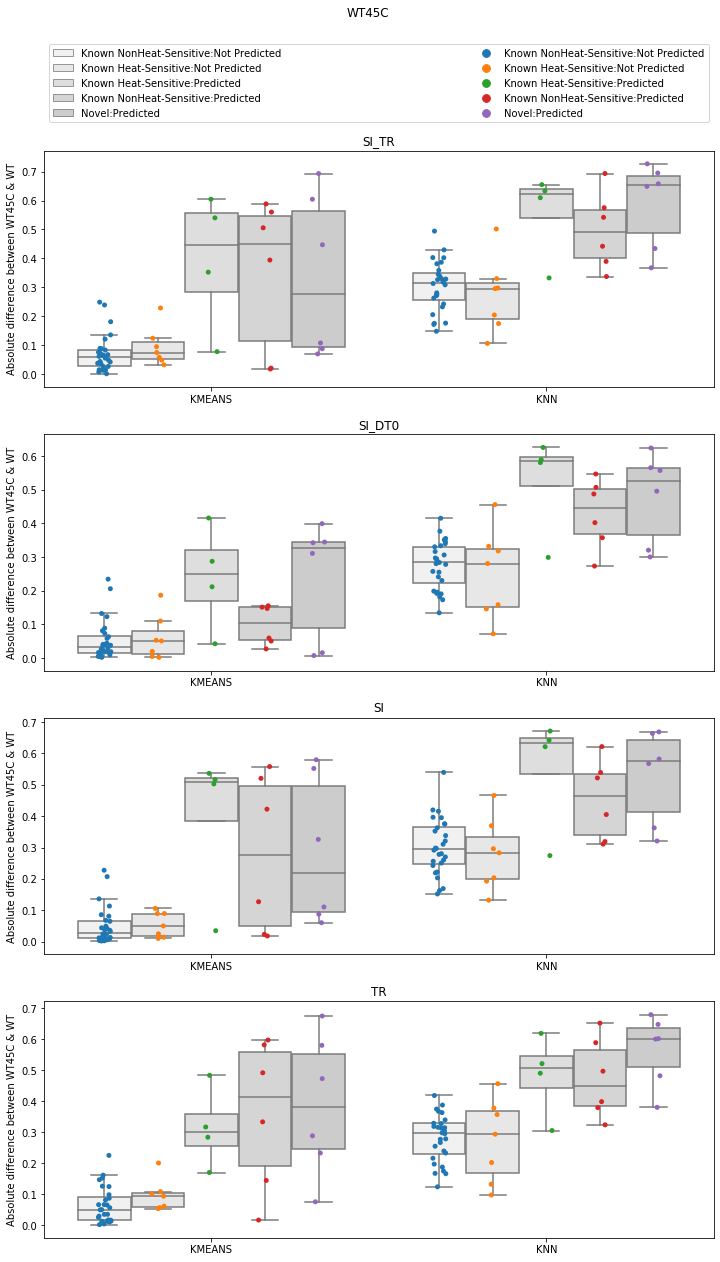

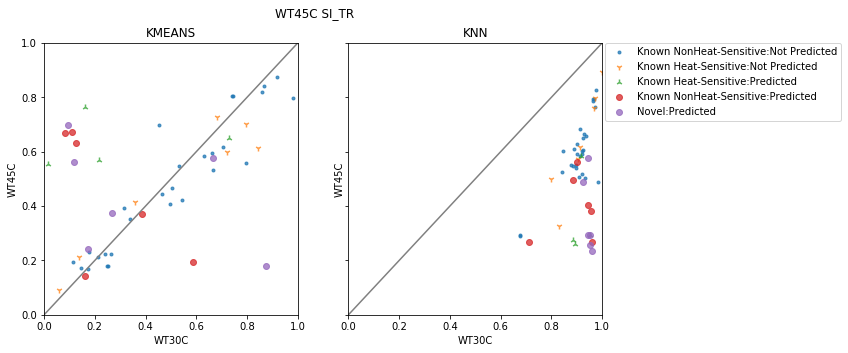

In [3]:
nn = 1 # how many neighbour positions to take into account
dt_shift = 10 # expected shift between center of the pore and motor protein in bases
features = ["si", "tr", "dt0"] # define features
feature_names = ["%s_%s"%(f.upper(), i) for f in features for i in range(-nn, nn+1)]

mt = "WT45C" #"Pus4KO30C" #"Pus1KO30C"
predictions = pd.read_csv("results/predictions_ncRNA_WT30C_%s.tsv.gz"%mt, sep="\t"); predictions.head()
predictions["chrom"] = predictions["chr_pos.x"].apply(lambda r: "_".join(r.split("_")[:-1]))
predictions["pos"] = predictions["chr_pos.x"].apply(lambda r: int(r.split("_")[-1]))
predictions["chr_pos"] = predictions["chrom"]+":"+predictions["pos"].astype("str")+"+"#redictions["chr_pos.x"].apply(lambda r: "_".join(r.split("_")))+"+"
print(predictions.shape, predictions.columns)
print([Counter(predictions[c]) for c in ("Heat", "New_Status", "Prediction")])

fasta = "guppy3.0.3.hac/Saccharomyces_cerevisiae.R64-1-1_firstcolumn.ncrna.fa" # reference FastA
bams = []
strains_unique = (mt, "WT30C")
for s in strains_unique:
    fnpat = "guppy3.0.3.hac/*%s.bam"%s# pattern for all BAM files
    bams += list(sorted(glob(fnpat), key=lambda fn: os.path.basename(fn).split("_")[-1])) # get KO
samples = [os.path.basename(fn).split(".")[0] for fn in bams]; print(bams, samples)

# Wanted palette details ("hls", "Blues", "YlOrBr", "light:b")
n_samples = len(samples)
colors =  sns.color_palette(n_colors=n_samples)#"flare"

# load features from BAM files
regions = [tuple(r[["chrom","pos","cds_strand"]]) for idx, r in predictions.iterrows()]; regions
strains = [s.split("_")[-1] for s in samples]; strains
region2data = load_data_reps(fasta, bams, regions, features, strains, strains_unique)

ext = "pdf"
outdir = "results/ncRNA"
if not os.path.isdir(outdir): os.makedirs(outdir)
cols_starts = [("SI", "TR"), ("SI", "DT0"), ("SI", ), ("TR", ), ] # which combinations of features shall we use?

# get predictions
dfKmeans = get_freq_clf(region2data, strains_unique, cols_starts, feature_names, clf=KMeans(n_clusters=2), clf_name="KMEANS")
dfKNN = get_freq_clf(region2data, strains_unique, cols_starts, feature_names)
dframes = []
xls = pd.ExcelWriter(os.path.join(outdir, '%s.tables.xlsx'%mt))
for clf_name, df in zip(("KMEANS", "KNN"), [dfKmeans, dfKNN]):
    df = df.set_index("chr_pos").join(predictions[["chr_pos", "Heat", "New_Status", "Prediction"]].set_index("chr_pos"), rsuffix="_other")    
    df["group"] = df[["New_Status","Prediction"]].agg(':'.join, axis=1)
    df.to_excel(xls, clf_name)#, index=False)
    dframes.append(df)
xls.close()
plot_boxplot(outdir, dframes[0], mt, method="KMEANS") # boxplot for KMEANS
df = pd.concat(dframes).reset_index() #reindex()#
df = df.set_index("chr_pos").join(predictions[["chr_pos", "Heat", "New_Status", "Prediction"]].set_index("chr_pos"), rsuffix="_other")
df["group"] = df[["New_Status","Prediction"]].agg(':'.join, axis=1)
plot_figures(outdir, df, mt, strains_unique)
# add one big table to the xls file
#df.to_excel(xls, "all", index=False); xls.close()

In [4]:
print(mt, len(region2data))
df = dframes[0] # only KMEANS
groups = df["group"].unique()
for group in groups:
    chr_pos = df[df["group"]==group].index.unique()
    sys.stderr.write(" %s %s    \r"%(group, len(chr_pos)))
    outdir = os.path.join("results/ncRNA", mt, group)
    if not os.path.isdir(outdir): os.makedirs(outdir)
    for cp in chr_pos: 
        ref, posstrand = cp.split(":")
        pos = int(posstrand[:-1])
        strand = posstrand[-1]
        mer, sdata = region2data[(ref, pos, strand)]
        #print(mt, group, cp, ref, pos, strand)
        plot_density(outdir, sdata, mt, group, ref, pos, strand, mer, feature_names, colors, ext="pdf")

WT45C 51


# mRNA predictions
Make sure you downloaded also yeast mRNA BAM files (42GB!). 

Pus4KO30C (238, 29) Index(['CHR_POS', 'cds_name', 'other_name', 'Heat', 'Reference', 'Enzyme',
       'rel_pos', 'cds_strand', 'normal1_cov', 'normal1_mis', 'normal1_c',
       'ko1_cov', 'ko1_mis', 'ko1_c', 'normal2_cov', 'normal2_mis',
       'normal2_c', 'ko2_cov', 'ko2_mis', 'ko2_c', 'diff_mis1', 'diff_mis2',
       'mis_normal_merged', 'mis_ko_merged', 'New_Status', 'Prediction',
       'chr_pos', 'chrom', 'pos'],
      dtype='object')
[Counter({'None': 185, 'Pus1': 19, 'Unm': 9, 'Cbf5': 8, 'Pus7': 7, 'Pus4': 4, 'Pus3,4?': 1, 'Pus3': 1, 'Pus1,7?': 1, 'Pus9': 1, 'Pus2': 1, 'Pus6': 1}), Counter({'Yes': 123, 'No': 106, 'Unm': 9}), Counter({'Known Non-target': 225, 'Novel': 9, 'Known Pus4-Target': 4}), Counter({'Not Predicted': 224, 'Predicted': 14})]
['/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam', '/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA100820_Pus4KO30C.bam', '/no_backup_isis/enovoa/base

[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus4KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_sel

Pus1KO30C (240, 29) Index(['CHR_POS', 'cds_name', 'other_name', 'Heat', 'Reference', 'Enzyme',
       'rel_pos', 'cds_strand', 'normal1_cov', 'normal1_mis', 'normal1_c',
       'ko1_cov', 'ko1_mis', 'ko1_c', 'normal2_cov', 'normal2_mis',
       'normal2_c', 'ko2_cov', 'ko2_mis', 'ko2_c', 'diff_mis1', 'diff_mis2',
       'mis_normal_merged', 'mis_ko_merged', 'New_Status', 'Prediction',
       'chr_pos', 'chrom', 'pos'],
      dtype='object')
[Counter({'None': 186, 'Pus1': 16, 'Unm': 10, 'Cbf5': 10, 'Pus7': 8, 'Pus4': 3, 'Pus2': 2, 'Pus3,4?': 1, 'Pus3': 1, 'Pus1,7?': 1, 'Pus9': 1, 'Pus6': 1}), Counter({'Yes': 126, 'No': 104, 'Unm': 10}), Counter({'Known Non-target': 214, 'Known Pus1-Target': 16, 'Novel': 10}), Counter({'Not Predicted': 227, 'Predicted': 13})]
['/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA598723_Pus1KO30C.bam', '/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus1KO30C.bam', '/no_backup_isis/enovoa

[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA598723_Pus1KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA598723_Pus1KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA598723_Pus1KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA598723_Pus1KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus1KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/Pus1KO30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/base

WT45C (209, 29) Index(['CHR_POS', 'cds_name', 'other_name', 'Heat', 'Reference', 'Enzyme',
       'rel_pos', 'cds_strand', 'normal1_cov', 'normal1_mis', 'normal1_c',
       'heat1_cov', 'heat1_mis', 'heat1_c', 'normal2_cov', 'normal2_mis',
       'normal2_c', 'heat2_cov', 'heat2_mis', 'heat2_c', 'diff_mis1',
       'diff_mis2', 'New_Status', 'Prediction', 'mis_normal_merged',
       'mis_heat_merged', 'chr_pos', 'chrom', 'pos'],
      dtype='object')
[Counter({'None': 166, 'Pus1': 14, 'Unm': 11, 'Pus7': 6, 'Cbf5': 6, 'Pus4': 4, 'Pus3,4?': 1, 'Pus3': 1}), Counter({'Yes': 117, 'No': 81, 'Unm': 11}), Counter({'Known Heat-Sensitive': 117, 'Known NonHeat-Sensitive': 81, 'Novel': 11}), Counter({'Not Predicted': 192, 'Predicted': 17})]
['/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/RNA290920_WT45C.bam', '/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT45C.bam', '/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/p

[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam
[INFO] maxDepth reached for chrXII:499307-499311 @ /no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/WT30C.bam

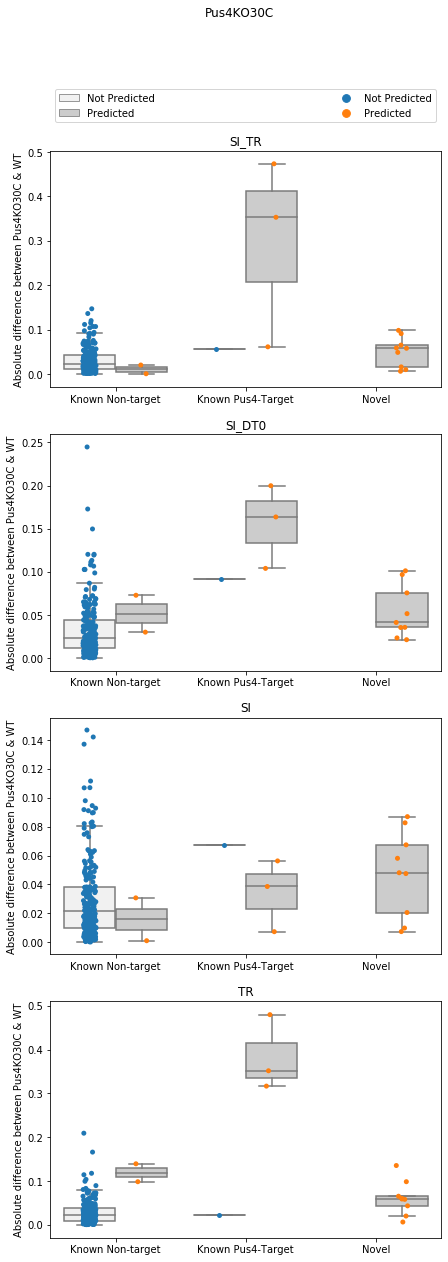

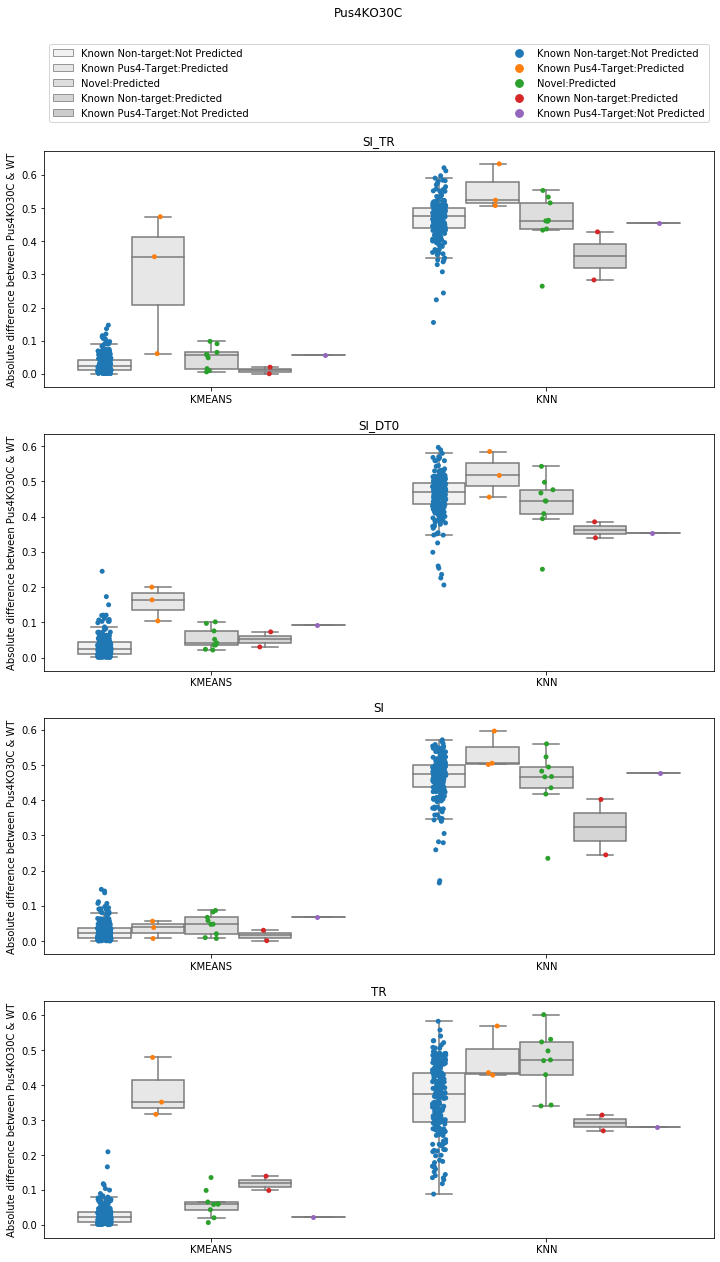

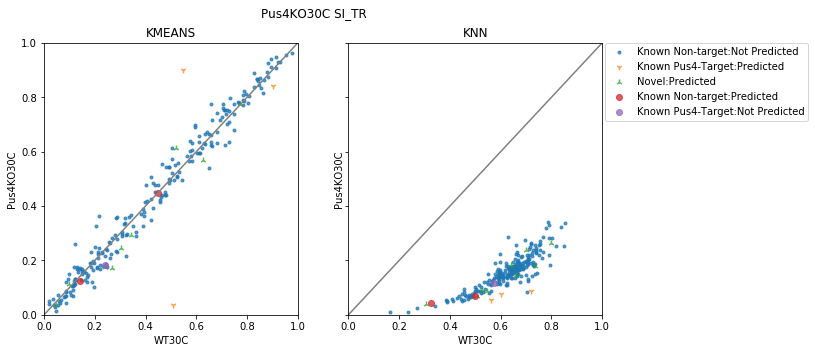

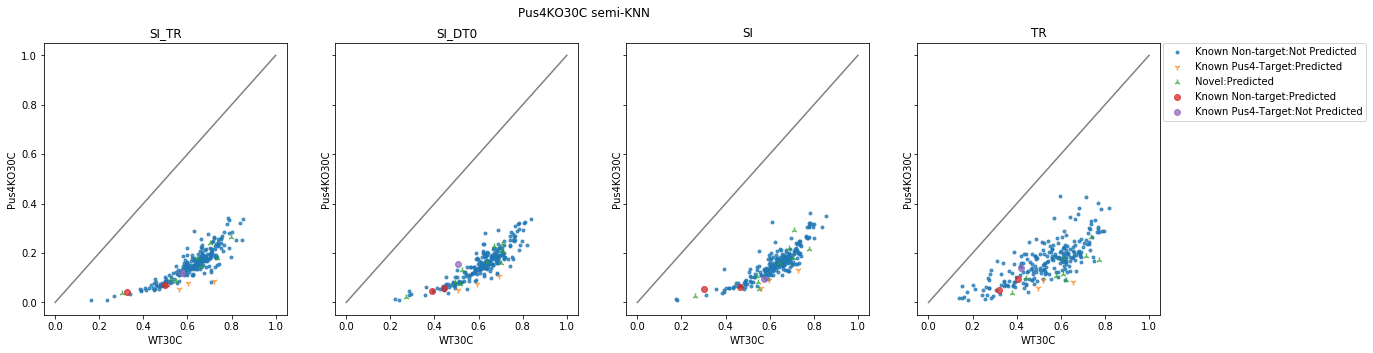

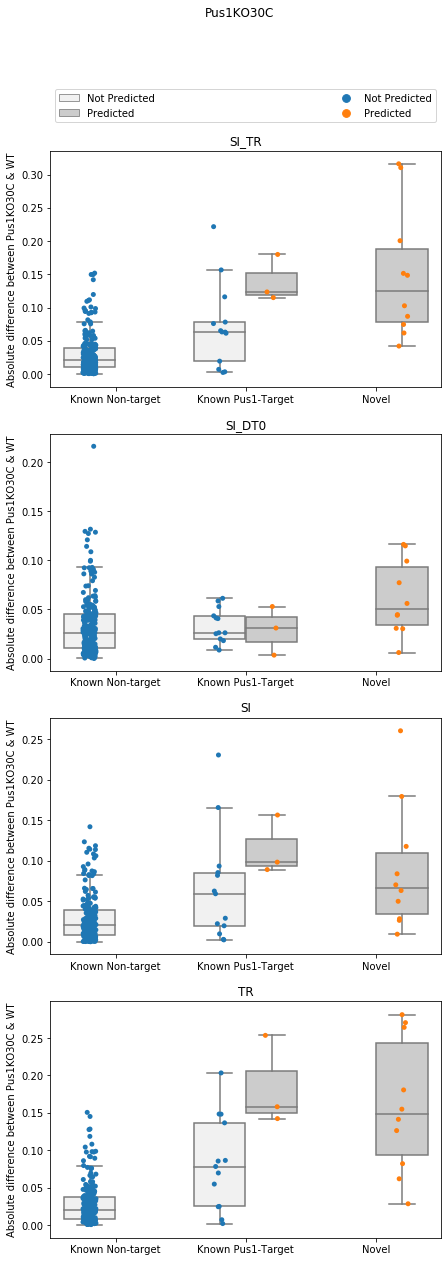

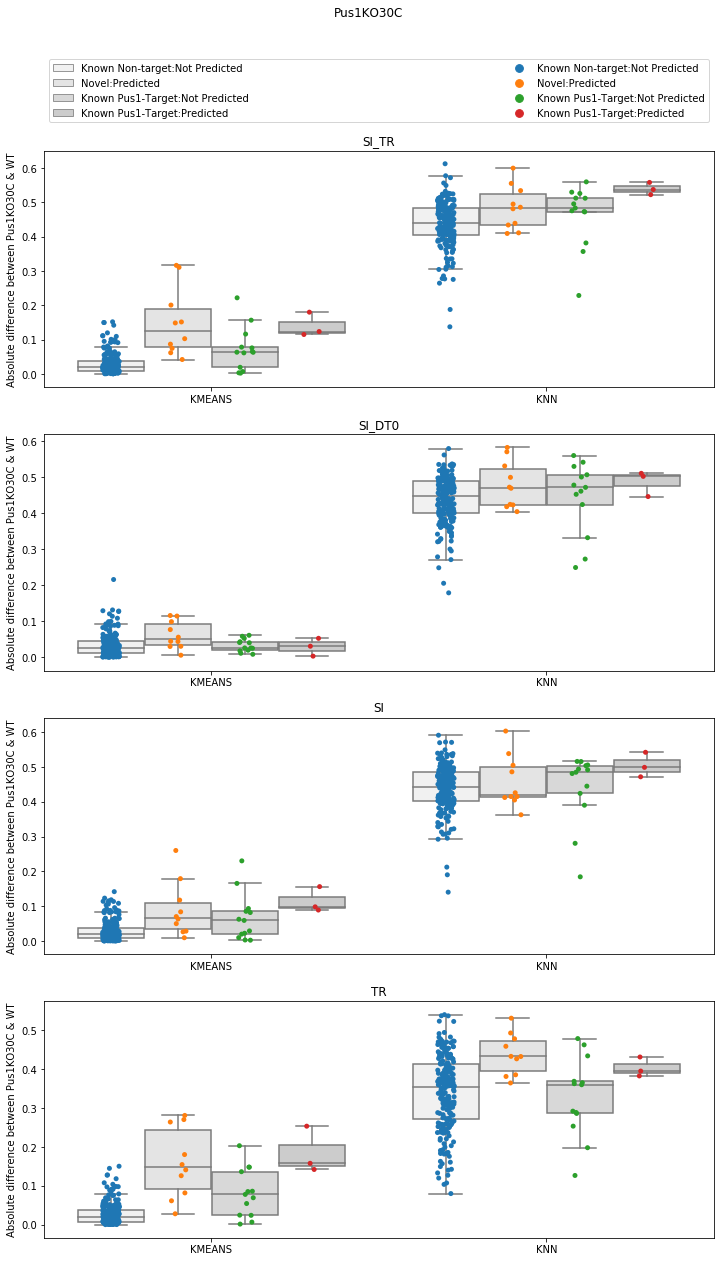

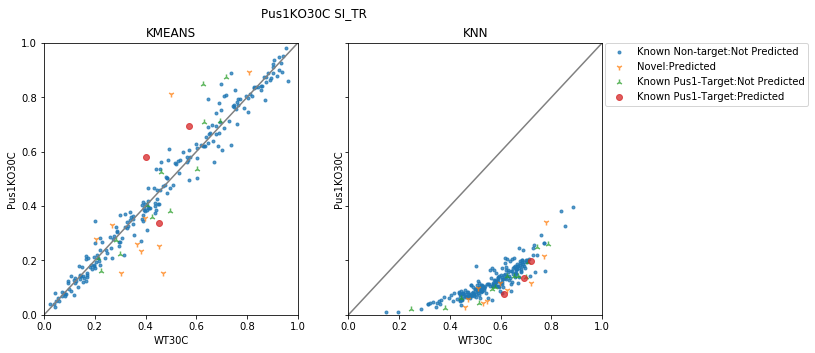

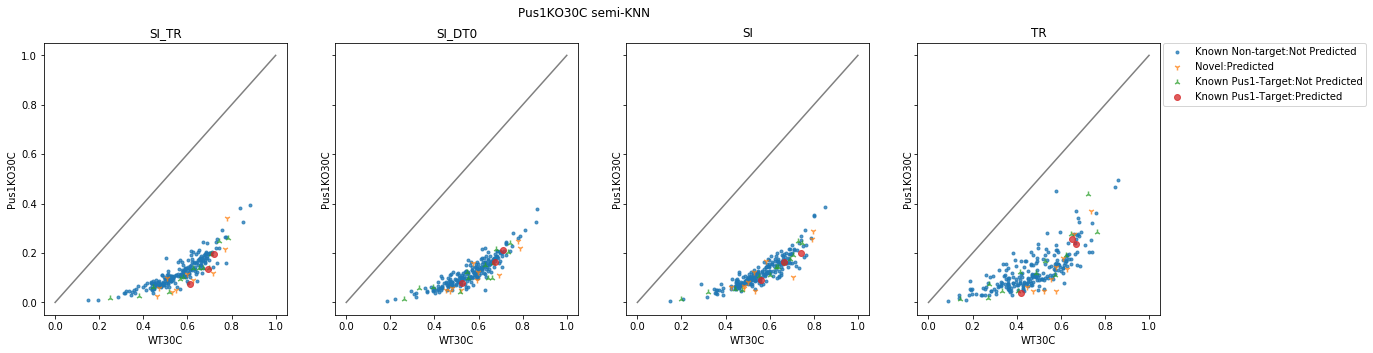

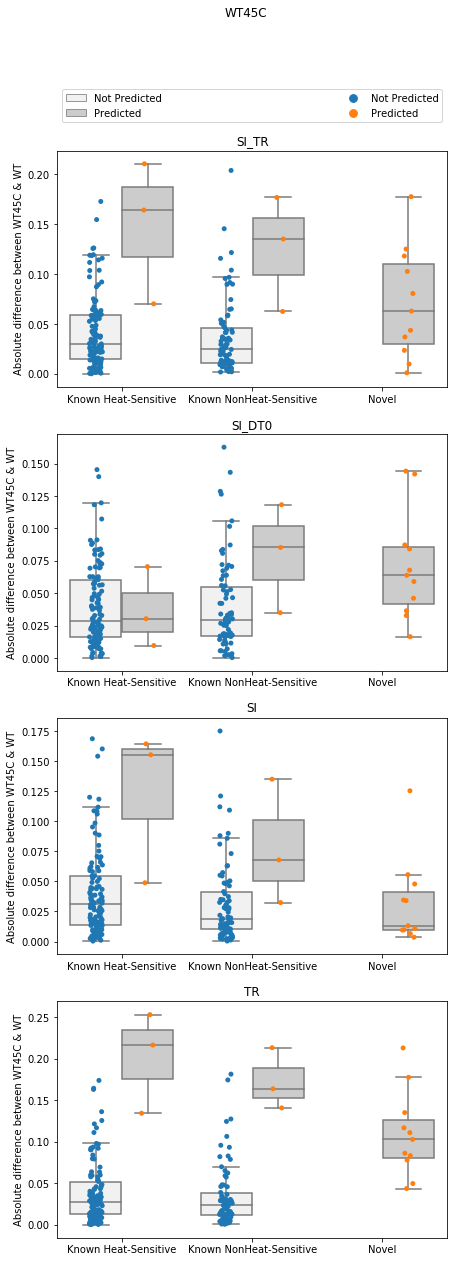

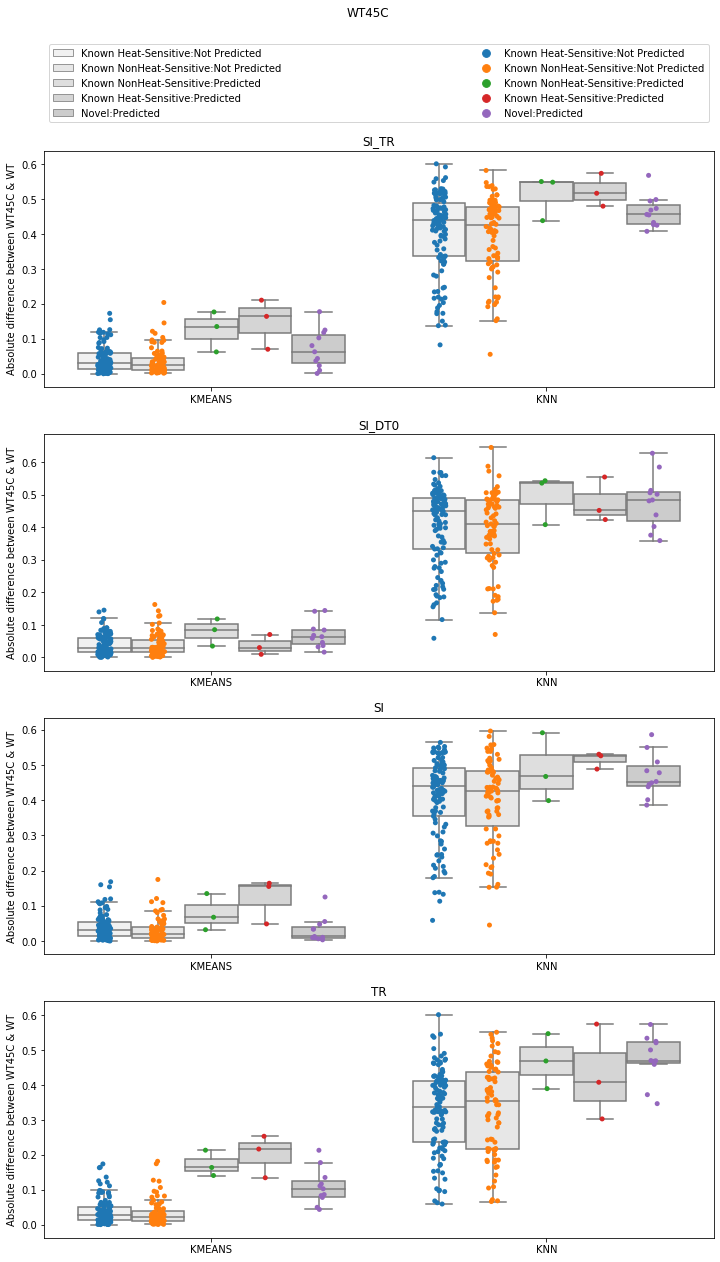

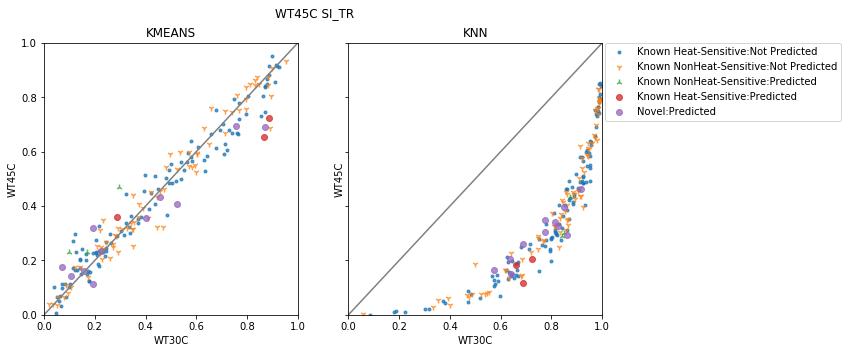

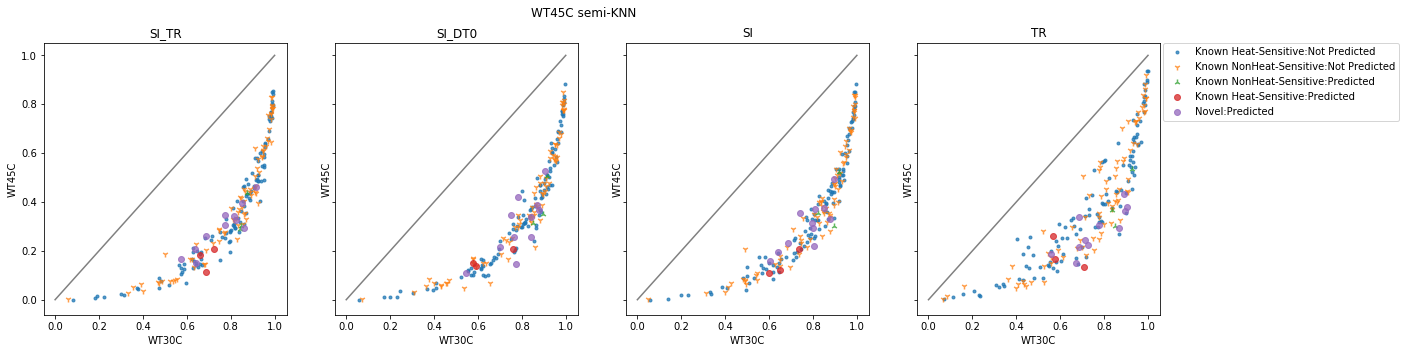

In [5]:
nn = 1 # how many neighbour positions to take into account
dt_shift = 10 # expected shift between center of the pore and motor protein in bases
features = ["si", "tr", "dt0"] # define features
feature_names = ["%s_%s"%(f.upper(), i) for f in features for i in range(-nn, nn+1)]
    
ext = "pdf"
outdir = "results/mRNA"
if not os.path.isdir(outdir): os.makedirs(outdir)
cols_starts = [("SI", "TR"), ("SI", "DT0"), ("SI", ), ("TR", ), ] # which combinations of features shall we use?
mt2dframes = {}
mt2region_data = {}
for mt in ("Pus4KO30C", "Pus1KO30C", "WT45C"): # "WT45C" #"Pus4KO30C" #"Pus1KO30C"
    predictions = pd.read_csv("results/predictions_mRNA_WT30C_%s.tsv.gz"%mt, sep="\t"); predictions.head()
    predictions["chr_pos"] = predictions["CHR_POS"].apply(lambda r: ":".join(r.split("_")))+predictions["cds_strand"]
    predictions["chrom"] = predictions["CHR_POS"].apply(lambda r: r.split("_")[0])
    predictions["pos"] = predictions["CHR_POS"].apply(lambda r: int(r.split("_")[1]))
    print(mt, predictions.shape, predictions.columns)
    print([Counter(predictions[c]) for c in ("Enzyme", "Heat", "New_Status", "Prediction")])

    fasta = "guppy3.0.3.hac/SacCer3.fa" # reference FastA
    bams = []
    strains_unique = (mt, "WT30C")
    for s in strains_unique:
        fnpat = "bams/*%s.bam"%s# pattern for all BAM files
        fnpat = "/no_backup_isis/enovoa/basecalling/guppy3.0.3/pus_project/polyA_selected/80_demux/*%s.bam"%s
        bams += list(sorted(glob(fnpat), key=lambda fn: os.path.basename(fn).split("_")[-1])) # get KO
    samples = [os.path.basename(fn).split(".")[0] for fn in bams]; print(bams, samples)

    # Wanted palette details ("hls", "Blues", "YlOrBr", "light:b")
    n_samples = len(samples)
    colors =  sns.color_palette(n_colors=n_samples)#"flare"
    
    # load features from BAM files
    regions = [tuple(r[["chrom","pos","cds_strand"]]) for idx, r in predictions.iterrows()]; regions
    strains = [s.split("_")[-1] for s in samples]; strains
    region2data = load_data_reps(fasta, bams, regions, features, strains, strains_unique)
    mt2region_data[mt] = region2data
    #continue
    # get predictions
    dfKmeans = get_freq_clf(region2data, strains_unique, cols_starts, feature_names, clf=KMeans(n_clusters=2), clf_name="KMEANS")
    dfKNN = get_freq_clf(region2data, strains_unique, cols_starts, feature_names)
    dframes = []
    xls = pd.ExcelWriter(os.path.join(outdir, '%s.tables.xlsx'%mt))
    for clf_name, df in zip(("KMEANS", "KNN"), [dfKmeans, dfKNN]):
        df = df.set_index("chr_pos").join(predictions[["chr_pos", "Heat", "New_Status", "Prediction"]].set_index("chr_pos"), rsuffix="_other")    
        df["group"] = df[["New_Status","Prediction"]].agg(':'.join, axis=1)
        df.to_excel(xls, clf_name)#, index=False)
        dframes.append(df)
    xls.close()
    plot_boxplot(outdir, dframes[0], mt, method="KMEANS") # boxplot for KMEANS
    df = pd.concat(dframes).reset_index()
    df = df.set_index("chr_pos").join(predictions[["chr_pos", "Heat", "New_Status", "Prediction"]].set_index("chr_pos"), rsuffix="_other")
    df["group"] = df[["New_Status","Prediction"]].agg(':'.join, axis=1)
    plot_figures(outdir, df, mt, strains_unique)
    # add one big table to the xls file
    #df.to_excel(xls, "all", index=False); xls.close()
    mt2dframes[mt] = dframes

In [6]:
for mt, dframes in mt2dframes.items():
    region2data = mt2region_data[mt]
    print(mt, len(region2data))
    df = dframes[0]
    groups = df["group"].unique()
    for group in groups:
        chr_pos = df[df["group"]==group].index.unique()
        sys.stderr.write(" %s %s    \r"%(group, len(chr_pos)))
        outdir = os.path.join("results/mRNA", mt, group)
        if not os.path.isdir(outdir): os.makedirs(outdir)
        for cp in chr_pos: 
            ref, posstrand = cp.split(":")
            pos = int(posstrand[:-1])
            strand = posstrand[-1]
            mer, sdata = region2data[(ref, pos, strand)]
            #print(mt, group, cp, ref, pos, strand)
            plot_density(outdir, sdata, mt, group, ref, pos, strand, mer, feature_names, colors)

Pus4KO30C 238


Pus1KO30C 240


WT45C 209
